In [1]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]


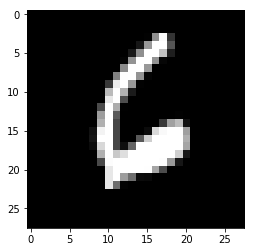

In [17]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

idx = 3
pixels = np.reshape(mnist.train.images[idx],(28,28))
plt.imshow(pixels, cmap='gray')

print(mnist.train.labels[idx])

In [29]:
xs, ys = mnist.train.next_batch(5)

In [111]:
?tf.Variable

In [141]:
# model.py
import tensorflow as tf

class Model():
    def __init__(self, n_input=784, n_output=10):
        self.n_input = n_input
        self.n_output = n_output
        print('variational auto-encoder')
        
    def _build_encoder(self, input_x, layer_config=20):    
        # variable setting
        W_enc = tf.Variable(tf.random_normal([self.n_input, layer_config]), name='weight_enc')
        b_enc = tf.Variable(tf.random_normal([layer_config]), name='bias_enc')
    

        # hidden layer, dim = batch_size X layer_config
        hidden_layer = tf.matmul(input_x, W_enc) + b_enc 
        
        
        mean = hidden_layer[:, :self.n_output]
        # The standard deviation must be positive. Parametrize with a softplus and
        # add a small epsilon for numerical stability
        stddev = 1e-6 + tf.nn.softplus(hidden_layer[:, self.n_output:])
        return mean, stddev
    
    def _build_decoder(self, mean, stddev, layer_config=20):
        
        # reparameterization
        eps = tf.random_normal(shape=[500, self.n_output], mean=0, stddev=1.0)
#         mean = tf.expand_dims(mean, 1)
#         stddev = tf.expand_dims(stddev, 1)
        z = mean + tf.multiply(stddev, eps)
        
        # reconstruction
        W_dec = tf.Variable(tf.random_normal([self.n_output, self.n_input]), name='weight_dec')
        b_dec = tf.Variable(tf.random_normal([self.n_input]), name='bias_dec')
    
        output = tf.nn.sigmoid(tf.matmul(z, W_dec) + b_dec)
        return output
    
    def loss(self, mean, stddev, input_x, output):
        kl_div = 0.5 * tf.reduce_sum(tf.square(mean) + tf.square(stddev) - tf.log(1e-8 + tf.square(stddev)) - 1, 1)
        
        input_matrix = tf.tile(input_x, [500, 1])
        recon_loss = tf.losses.mean_squared_error(input_matrix, output)

        return recon_loss+kl_div
    
    def vae(self, input_x, layer_config=20):
        mean, stddev = self._build_encoder(input_x, layer_config=layer_config)
        output = self._build_decoder(mean=mean, stddev=stddev, layer_config=layer_config)
        cost = self.loss(mean=mean, stddev=stddev, input_x=input_x, output=output)
        return cost, output

In [142]:
model = Model(n_input=784, n_output=10)

variational auto-encoder


In [144]:
# run_vae

X = tf.placeholder(tf.float32, shape=[1, 784])
cost, output = model.vae(input_x=X, layer_config=20)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(cost)


n_batch_samples = 1
n_epochs = 100

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(n_epochs):
        xs, ys = mnist.train.next_batch(n_batch_samples)
        c, op = sess.run([cost, optimizer], feed_dict={X:xs})
        print(c)

[ 793.22143555]
[ 252.9221344]
[ 116.22473145]
[ 728.36547852]
[ 422.59490967]
[ 981.70623779]
[ 300.06384277]
[ 735.64874268]
[ 199.81652832]
[ 304.18099976]
[ 833.05023193]
[ 220.46443176]
[ 221.77069092]
[ 640.08203125]
[ 608.39086914]
[ 421.16760254]
[ 246.52879333]
[ 205.95246887]
[ 127.86470795]
[ 597.09545898]
[ 228.17810059]
[ 207.65666199]
[ 353.17089844]
[ 241.95985413]
[ 76.56932068]
[ 192.01828003]
[ 184.66157532]
[ 319.41827393]
[ 236.05871582]
[ 202.53993225]
[ 148.14337158]
[ 187.22245789]
[ 304.21090698]
[ 193.61317444]
[ 321.28485107]
[ 196.39134216]
[ 341.12863159]
[ 141.67871094]
[ 271.84838867]
[ 287.15536499]
[ 513.269104]
[ 155.19831848]
[ 261.8012085]
[ 282.79199219]
[ 220.83836365]
[ 258.04415894]
[ 78.38423157]
[ 204.65939331]
[ 147.23995972]
[ 330.83218384]
[ 121.59132385]
[ 261.11755371]
[ 222.9957428]
[ 216.49000549]
[ 125.56491089]
[ 301.6413269]
[ 290.82144165]
[ 224.91046143]
[ 358.40710449]
[ 301.84875488]
[ 244.65896606]
[ 169.57452393]
[ 274.74099731]


In [ ]:
# batch인 경우 풀어서  w matmul, 그다음에 다시 reshape